# Hyperspectral image ground classification
## Using Machine Learning

In [3]:
import utils as u
import preprocessing as pp
import train as tt
import visualization as viz

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Activation, Average, Dense, Flatten
from keras.layers.convolutional import AveragePooling3D, Conv3D
from keras.models import Model
from keras.optimizers import SGD
from keras.engine.input_layer import Input
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU, ThresholdedReLU
from keras import regularizers
from keras.regularizers import l2
from IPython.display import SVG
from IPython.display import Image

from keras.utils.vis_utils import model_to_dot

from keras import backend as K
K.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')
from keras.utils import np_utils

import spectral
from spectral import spy_colors

#tests
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

/home/meryll/miniconda3/envs/eca/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Globals and hyperparameters

In [1]:
numPCAcomponents = 100
PATCH_SIZE = 5
C1 = 3*numPCAcomponents

batch_size = 128
epochs = 10

classes_authorized = [2,3,5,6,10,0,11,12,14,15]
num_classes = 9

target_names = ['Maïs- Pas de Technique de Conservation des sols',
                    'Maïs- Minimum Tillage',
                    'Herbe-Pâturage',
                    'Herbe-Arbre',
                    'Soja-Pas de Technique de Conservation des sols', 'Soja-Minimum Tillage','Soja', 'Bois',
                    'Bâtiment-Herbe-Arbre-drives',]

label_dictionary = {
    0: 'Rien',
    1: 'Maïs- Pas de Technique de Conservation des sols', 
    2: 'Maïs- Minimum Tillage',
    3: 'Herbe-Pâturage', 
    4: 'Herbe-Arbre', 
    5: 'Soja-Pas de Technique de Conservation des sols', 
    6: 'Soja-Minimum Tillage',
    7: 'Soja', 
    8: 'Bois', 
    9: 'Bâtiment-Herbe-Arbre-drives',
}

### Preprocessing

In [2]:
X, train_data, test_data = pp.loadData()

NameError: name 'pp' is not defined

In [ ]:
train_data = pp.deleteUselessClasses(train_data, classes_authorized)
test_data = pp.deleteUselessClasses(test_data, classes_authorized)

def pretty_print_count(train_data, test_data):
    unique_train = np.unique(train_data, return_counts=True)
    unique_test = np.unique(test_data, return_counts=True)
    for i in range(0, unique_train[0].shape[0]):
        print(unique_train[0][i], "=>", unique_train[1][i], "/", unique_test[1][i])
    print()
        
print("Before Shuffle: ")
pretty_print_count(train_data, test_data)
train_data, test_data = pp.shuffleTrainTest(train_data, test_data)
print("After Shuffle: ")
pretty_print_count(train_data, test_data)

In [ ]:
# APPLIES PCA
X, pca = pp.dimensionalityReduction(X, numComponents=numPCAcomponents, standardize=False)

In [ ]:
# CREATE PATCHES, DELETE 0 VALUES
X_train, X_test, y_train, y_test = pp.patch_1dim_split(X, train_data, test_data, PATCH_SIZE)

In [22]:
X_train, y_train = pp.BoostDataset(X_train, y_train, n_samples=100)

Boosting Dataset...
Progress:  |████████████████████████████████████████| 100.0%  Complete


In [ ]:
y_train = np_utils.to_categorical(y_train, num_classes=9)
y_test = np_utils.to_categorical(y_test, num_classes=9)

### END PREPROCESSING ###

In [8]:
## Prints preprocessing

t,v = np.unique(train_data, return_counts=True)
print(t, v)
t,v = np.unique(test_data, return_counts=True)
print(t, v)


[0 1 2 3 4 5 6 7 8 9] [16441   700   435   249   382   481  1205   317   635   180]
[0 1 2 3 4 5 6 7 8 9] [16467   728   395   234   348   491  1250   276   630   206]


### Train our model

In [ ]:
input_shape= X_train[0].shape
print(input_shape)

In [ ]:
model = Sequential()
    
model.add(Conv2D(C1, (2,2), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3,3), activation='relu'))
model.add(Dropout(0.25))

model.add(AveragePooling2D(pool_size=(1, 1), strides=(1, 1)))
model.add(Flatten())
model.add(Dense(30*numPCAcomponents, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

model.summary()
#Image(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='png'))


# On a 9 classes en réalité, donc une accuracy > 100/9 ~=11.11 est supérieure au hasard. 
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

### Visualization

In [ ]:
classification, confusion, Test_loss, Test_accuracy = viz.reports(model, X_test,y_test, target_names)
print(classification)

Normalized confusion matrix


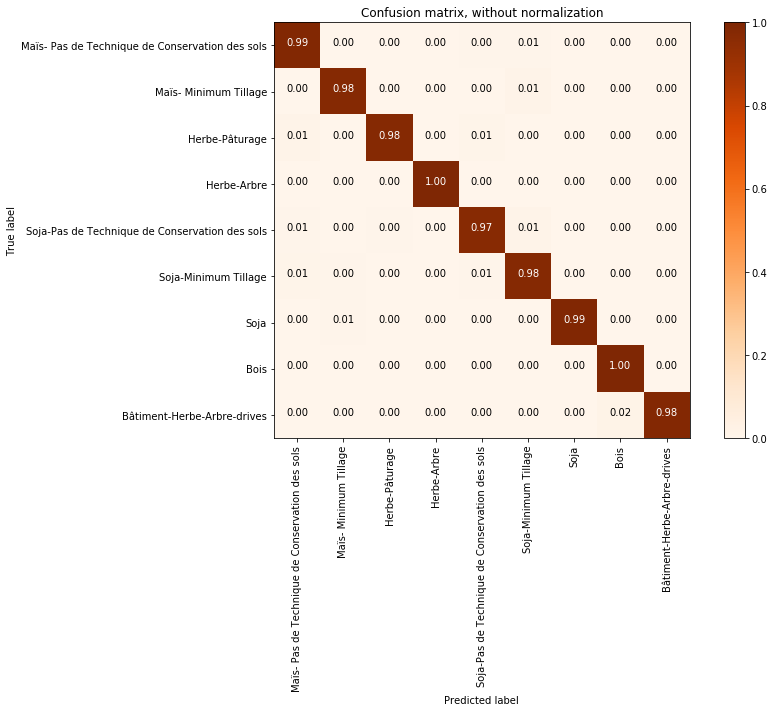

In [200]:
plt.figure(figsize=(13, 10))
viz.plot_confusion_matrix(confusion, classes=target_names,
                      title='Confusion matrix, without normalization')

In [201]:
X_garbage, train_data, test_data = pp.loadData()
#X = dimensionalityReduction(X, )
y = np.add(train_data, test_data)
y = pp.deleteUselessClasses(y, classes_authorized)

In [202]:
outputs = viz.createPredictedImage(X, y, model, 5, y.shape[0], y.shape[1])

Progress:  |████████████████████████████████████████| 100.0%  Complete


PREDICTED IMAGE:


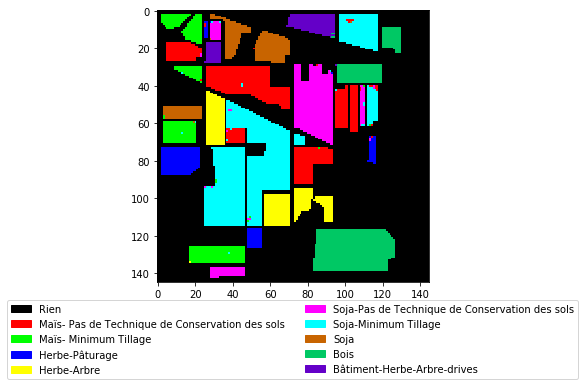

In [204]:
print("PREDICTED IMAGE:")
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))
labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=label_dictionary[x]) for x in np.unique(y) ]
plt.legend(handles=labelPatches, ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05));

IDEAL IMAGE: 


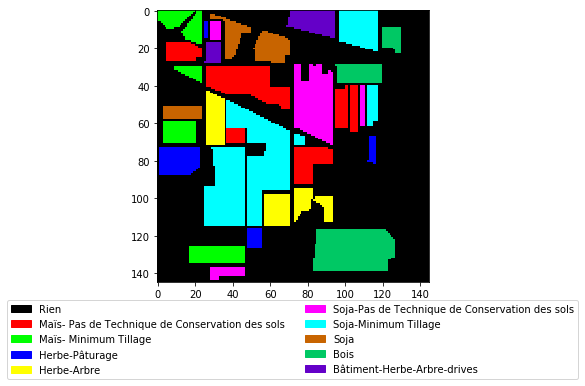

In [27]:
ground_truth = spectral.imshow(classes = y,figsize =(5,5))
print("IDEAL IMAGE: ")

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=label_dictionary[x]) for x in np.unique(y) ]
plt.legend(handles=labelPatches, ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05));

## Machine Learning algorithms

### Not our best results but some are good

In [42]:
X, train_data, test_data = pp.loadData()

In [43]:
train_data = pp.deleteUselessClasses(train_data, classes_authorized)
test_data = pp.deleteUselessClasses(test_data, classes_authorized)

def pretty_print_count(train_data, test_data):
    unique_train = np.unique(train_data, return_counts=True)
    unique_test = np.unique(test_data, return_counts=True)
    for i in range(0, unique_train[0].shape[0]):
        print(unique_train[0][i], "=>", unique_train[1][i], "/", unique_test[1][i])
    print()
        
print("Before Shuffle: ")
pretty_print_count(train_data, test_data)
train_data, test_data = pp.shuffleTrainTest(train_data, test_data)
print("After Shuffle: ")
pretty_print_count(train_data, test_data)

Before Shuffle: 
0 => 15155 / 17753
1 => 648 / 780
2 => 751 / 79
3 => 465 / 18
4 => 492 / 238
5 => 231 / 741
6 => 1646 / 809
7 => 403 / 190
8 => 1145 / 120
9 => 89 / 297

After Shuffle: 
0 => 16441 / 16467
1 => 700 / 728
2 => 435 / 395
3 => 249 / 234
4 => 382 / 348
5 => 481 / 491
6 => 1205 / 1250
7 => 317 / 276
8 => 635 / 630
9 => 180 / 206



In [39]:
X, pca = pp.dimensionalityReduction(X, numComponents=numPCAcomponents, standardize=False)

In [44]:
X_train, X_test, y_train, y_test = pp.split(X, train_data, test_data)

In [12]:
neigh = KNeighborsClassifier(n_neighbors=10)
tt.train_test_model(neigh, X_train, y_train, X_test, y_test, target_names)

Model f1_score on train data/labels: 0.7160554968694586 

Model score on test data/labels:
                                                 precision    recall  f1-score   support

Maïs- Pas de Technique de Conservation des sols       0.59      0.59      0.59       728
                          Maïs- Minimum Tillage       0.57      0.42      0.48       395
                                 Herbe-Pâturage       0.81      0.73      0.76       234
                                    Herbe-Arbre       0.76      0.95      0.84       348
 Soja-Pas de Technique de Conservation des sols       0.55      0.51      0.53       491
                           Soja-Minimum Tillage       0.62      0.80      0.70      1250
                                           Soja       0.60      0.29      0.40       276
                                           Bois       0.87      0.90      0.88       630
                    Bâtiment-Herbe-Arbre-drives       0.74      0.21      0.33       206

                 

In [14]:
dtree = DecisionTreeClassifier(max_depth=10, criterion="entropy", max_leaf_nodes=50)
tt.train_test_model(dtree, X_train, y_train, X_test, y_test, target_names)

Model f1_score on train data/labels: 0.7091772384250378 

Model score on test data/labels:
                                                 precision    recall  f1-score   support

Maïs- Pas de Technique de Conservation des sols       0.61      0.54      0.57       728
                          Maïs- Minimum Tillage       0.54      0.47      0.50       395
                                 Herbe-Pâturage       0.75      0.77      0.76       234
                                    Herbe-Arbre       0.85      0.90      0.88       348
 Soja-Pas de Technique de Conservation des sols       0.58      0.62      0.60       491
                           Soja-Minimum Tillage       0.64      0.75      0.69      1250
                                           Soja       0.68      0.34      0.45       276
                                           Bois       0.89      0.91      0.90       630
                    Bâtiment-Herbe-Arbre-drives       0.54      0.47      0.50       206

                 

In [ ]:
svc = SVC(C=9, decision_function_shape="ovo")
tt.train_test_model(svc, X_train, y_train, X_test, y_test, target_names)

In [ ]:
X_train2 = (X_train - np.min(X_train))
X_test2 = (X_test - np.min(X_test))
multi = MultinomialNB(alpha=0.001)
tt.train_test_model(multi, X_train2, y_train, X_test2, y_test, target_names)